# Импорт библиотек

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re 

In [2]:
pd.options.display.max_columns = 100

In [3]:
#загружаем файл с данными
try:
    citys = pd.read_csv('forFBpost.csv', sep=';')
except:
    print('Файл не найден')

# Анализ данных

In [4]:
citys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30250 entries, 0 to 30249
Data columns (total 6 columns):
Город              30250 non-null object
year               30250 non-null int64
fact               3250 non-null float64
Модель             30250 non-null float64
Нижняя граница     30250 non-null float64
Верхняя граница    30250 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [5]:
#Таблица справочник - наименования столбцов
columns=['name','desc']
data = [
    ['city','Город'],
    ['year','year'],
    ['fact','fact'],
    ['model','Модель'],
    ['min','Нижняя граница'],
    ['max','Верхняя граница'],          
]

columns_names = pd.DataFrame(columns=columns, data=data)


def rename_cols(data,col_desc) -> pd.DataFrame:
    """
    rename columns by list of names and descriptions
    """
    for i, row in col_desc.iterrows():
        try:
            print(f"{row['desc']} -> {row['name']}")
            data = data.rename(columns={row['desc']:row['name']})
        except: print(f"column {row['desc']} not exist")
    return data

citys = rename_cols(citys, columns_names)
citys = citys.fillna(0)
display(citys.head(10))

Город -> city
year -> year
fact -> fact
Модель -> model
Нижняя граница -> min
Верхняя граница -> max


,city,year,fact,model,min,max
0,Белокуриха,2000,0.0,15400.0,15100.0,15700.0
1,Белокуриха,2001,0.0,15400.0,15100.0,15700.0
2,Белокуриха,2002,0.0,15400.0,15000.0,15700.0
3,Белокуриха,2003,0.0,15300.0,15000.0,15700.0
4,Белокуриха,2004,0.0,15300.0,14900.0,15600.0
5,Белокуриха,2005,0.0,15200.0,14800.0,15500.0
6,Белокуриха,2006,0.0,15100.0,14700.0,15400.0
7,Белокуриха,2007,0.0,15000.0,14600.0,15300.0
8,Белокуриха,2008,14781.0,14900.0,14600.0,15200.0
9,Белокуриха,2009,14781.0,14800.0,14500.0,15100.0


In [6]:
def city_selec (start_year_fact, end_year_fact, end_year_model):
    result = (
        citys.loc[citys['year'] == start_year_fact][['city','fact']]
        .merge(citys.loc[citys['year'] == end_year_fact][['city','fact']], on='city', 
                     suffixes=['_'+str(start_year_fact),'_'+str(end_year_fact)])
    
        .merge(citys.loc[citys['year'] == end_year_model][['city','model']], on='city', 
                     suffixes=['_'+str(end_year_model),''])    
    )

    result = result.rename(columns={'model':'model_'+str(end_year_model)})    
    return result


citys_08_20_40 = city_selec(2008, 2020, 2040)


citys_08_20_40['fact_dinamik'] = citys_08_20_40['fact_2020']/citys_08_20_40['fact_2008']
citys_08_20_40['model_dinamik'] = citys_08_20_40['model_2040']/citys_08_20_40['fact_2020']

display(citys_08_20_40)

,city,fact_2008,fact_2020,model_2040,fact_dinamik,model_dinamik
0,Белокуриха,14781.0,15176.0,17300.0,1.026723,1.139958
1,Новоалтайск,70454.0,74163.0,81000.0,1.052644,1.092189
2,Краснодар,782547.0,1014996.0,1220600.0,1.297042,1.202566
3,Анапа,141105.0,199851.0,304700.0,1.416328,1.524636
4,Бородино,17146.0,16058.0,14900.0,0.936545,0.927886
...,...,...,...,...,...,...
257,Алатырь,41975.0,33394.0,32200.0,0.795569,0.964245
258,Новочебоксарск,126895.0,127706.0,145300.0,1.006391,1.137770
259,Мирный,37386.0,35403.0,41100.0,0.946959,1.160919
260,Якутск,276821.0,343423.0,467500.0,1.240596,1.361295


In [7]:
def show_graph(data, top_city):        
    for id, сitys in top_city.iterrows():        
        fact = (
                        data.query(f"city == \"{сitys['city']}\" and year >= 2008 and year <= 2020")
                        .pivot_table(index='city',columns='year', values='fact')
        )
        model = (
                        data.query(f"city == \"{сitys['city']}\" and year >= 2008 and year <= 2040")
                        .pivot_table(index='city',columns='year', values='model')
        )
        fig = plt.figure(figsize=(20, 5)) #создание фигуры для рисования графиков 
        ax = fig.add_subplot(111) #создание осей координат для рисования графиков         
        fact.loc[сitys['city']].plot(#linestyle=line_v, color=color_v, 
                         ax=ax, grid=True, rot=45, alpha=0.7, label='label', title=сitys['city'])  
        model.loc[сitys['city']].plot(#linestyle=line_v, color=color_v, 
                         ax=ax, grid=True, rot=45, alpha=0.7, label='label')  

'Топ 5 городов за период с 2008 по 2020'

,city,fact_2008,fact_2020,fact_dinamik
0,Магас,4431.0,8295.0,1.872038
1,Краснослободск,10072.0,18571.0,1.843824
2,Краснослободск,10072.0,18571.0,1.843824
3,Анапа,141105.0,199851.0,1.416328
4,Михайловка,63007.0,86792.0,1.377498


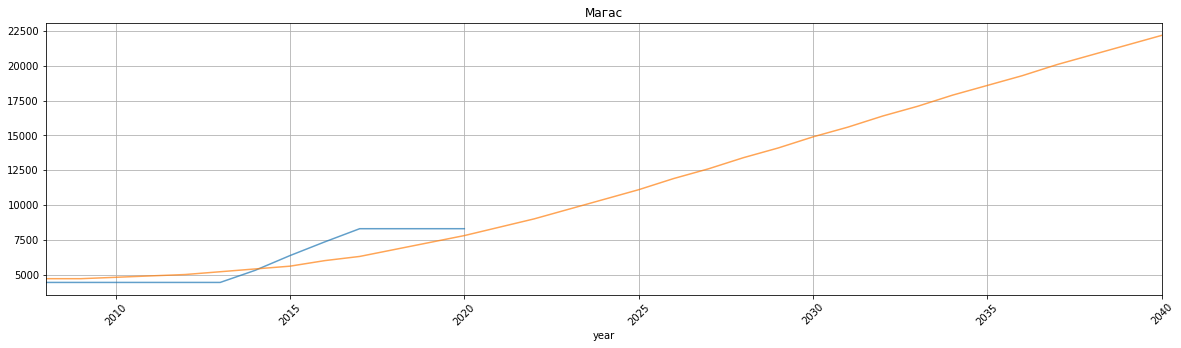

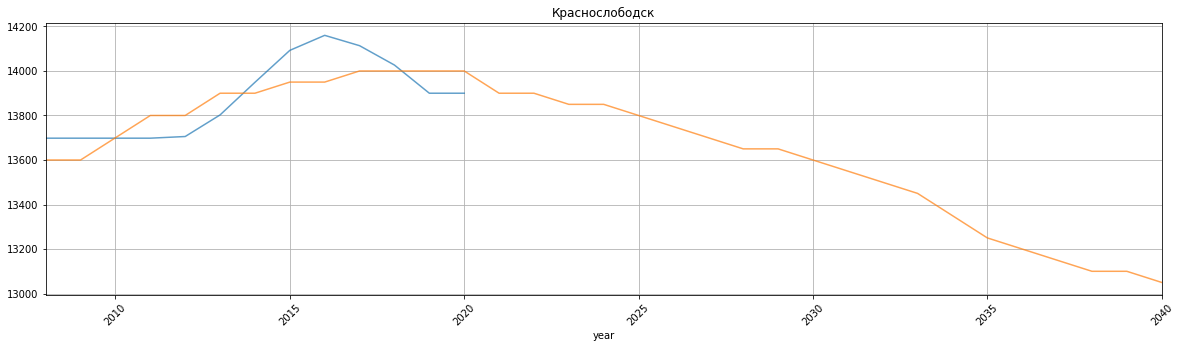

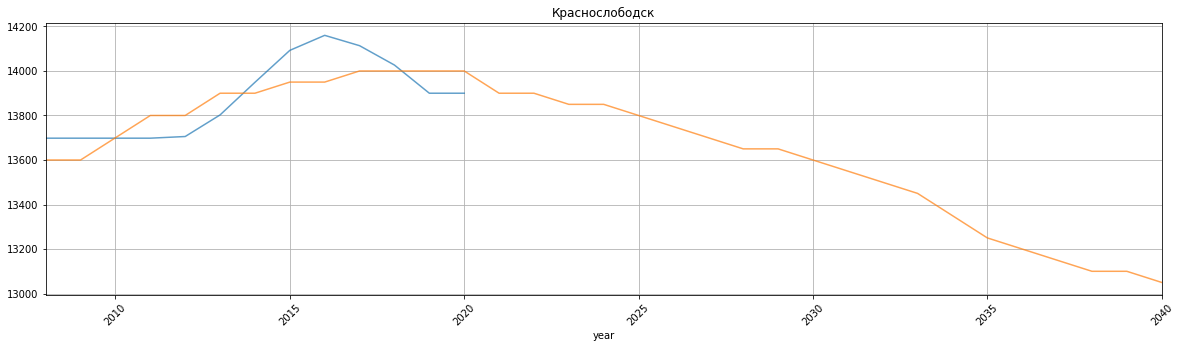

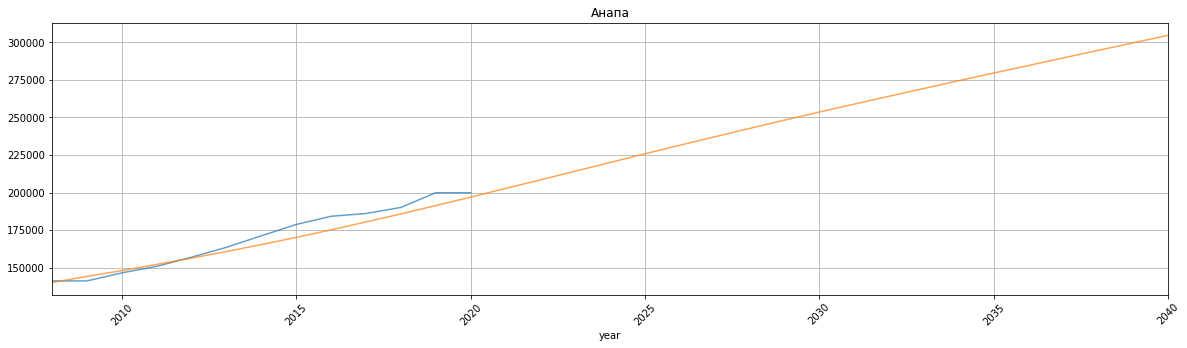

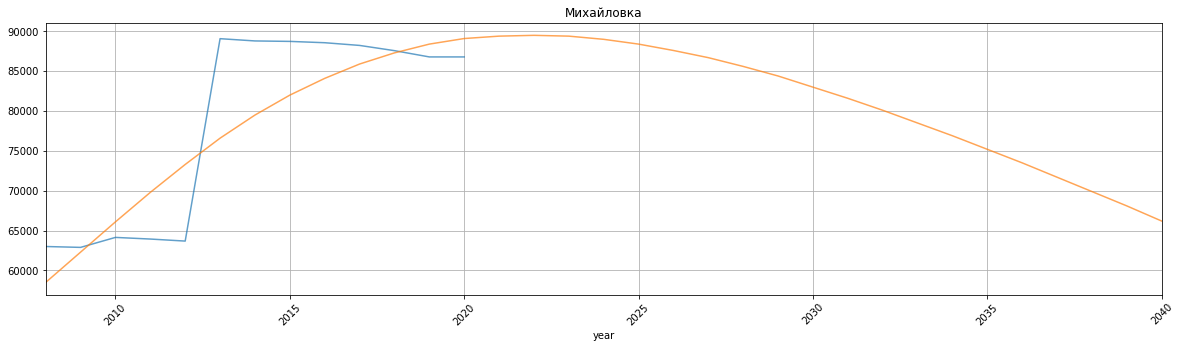

In [8]:
display('Топ 5 городов за период с 2008 по 2020')
top_10_citys_fact = citys_08_20_40.sort_values(by='fact_dinamik', ascending=False).head(5)
display(top_10_citys_fact[['city','fact_2008','fact_2020','fact_dinamik']].reset_index(drop=True))
show_graph(citys, top_10_citys_fact)

'Топ 5 худьших городов за период с 2008 по 2020'

,city,fact_2008,fact_2020,fact_dinamik
0,Краснослободск,17324.0,9229.0,0.532729
1,Краснослободск,17324.0,9229.0,0.532729
2,Воркута,111983.0,72773.0,0.649858
3,Инта,39088.0,26559.0,0.679467
4,Александровск-Сахалинский,15041.0,10768.0,0.715910


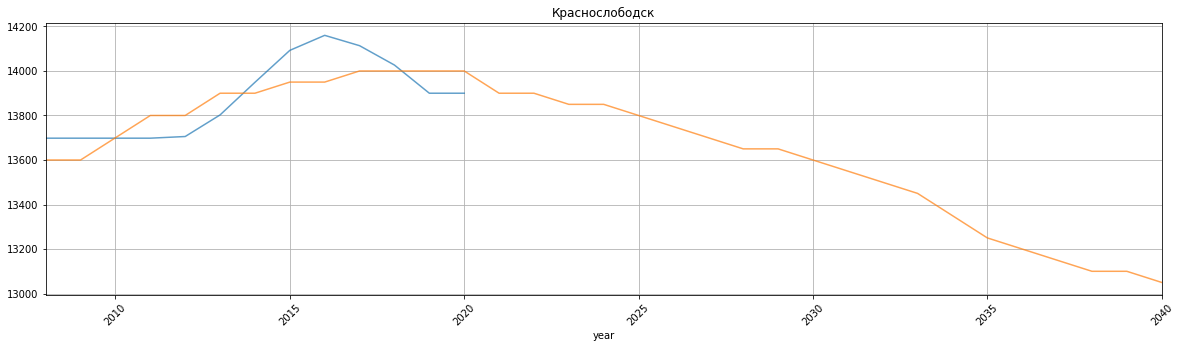

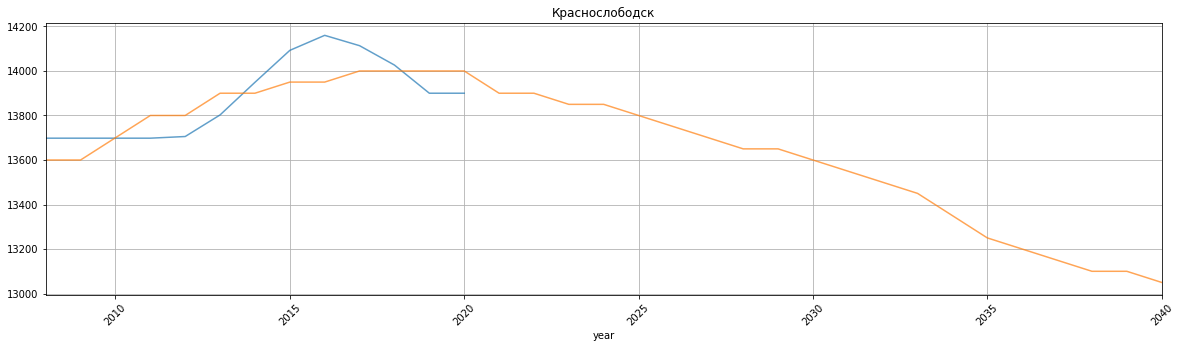

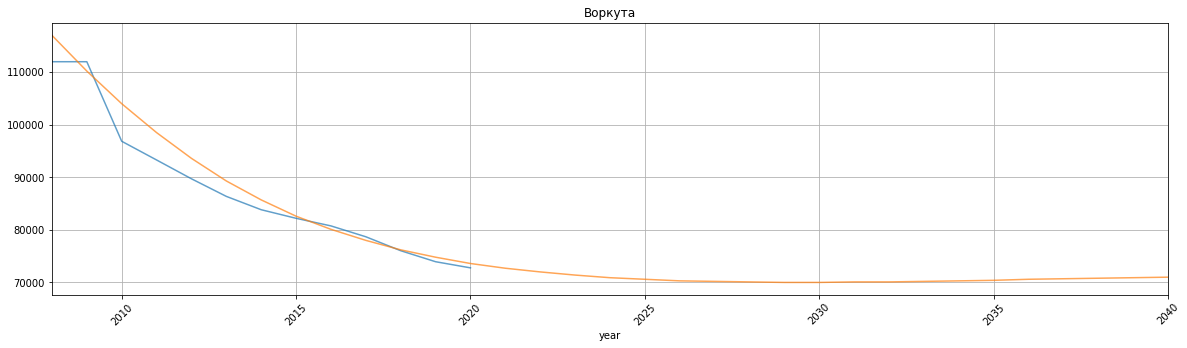

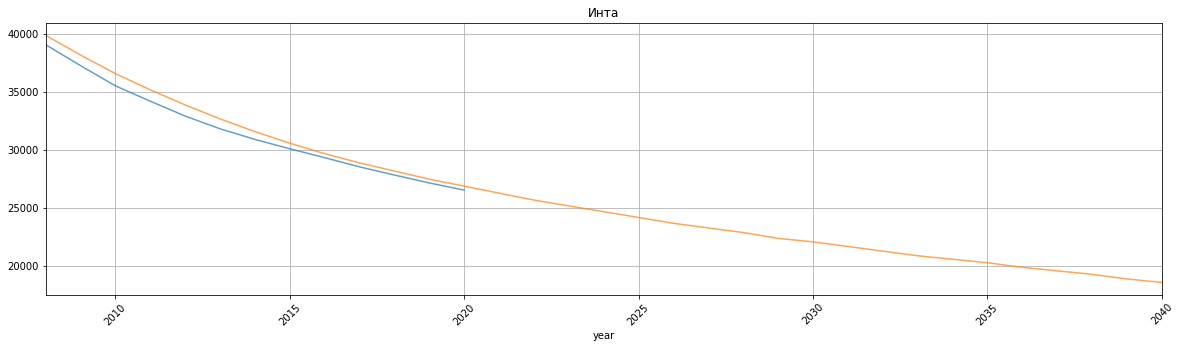

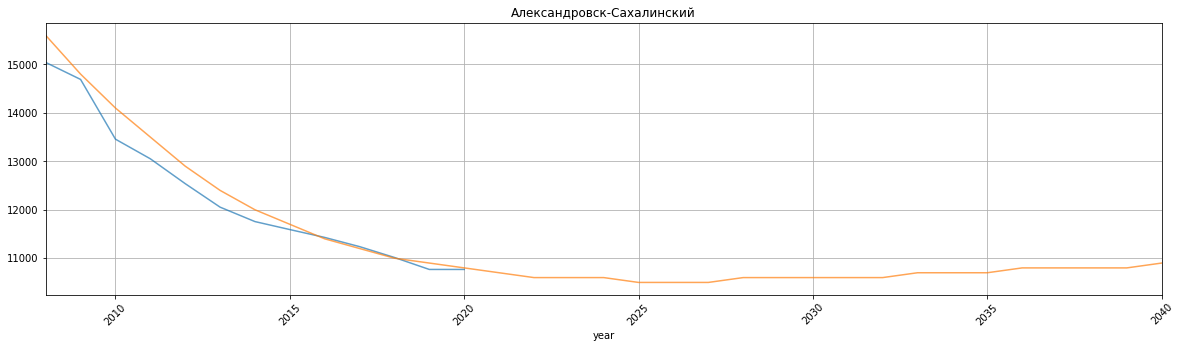

In [9]:
display('Топ 5 худьших городов за период с 2008 по 2020')
bottom_10_citys_fact = citys_08_20_40.sort_values(by='fact_dinamik', ascending=True).head(5)
display(bottom_10_citys_fact[['city','fact_2008','fact_2020','fact_dinamik']].reset_index(drop=True))
show_graph(citys, bottom_10_citys_fact)

'Топ 5 городов по прогнозам модели к 2040'

,city,fact_2020,model_2040,model_dinamik
0,Гудермес,56521.0,169900.0,3.005962
1,Магас,8295.0,22200.0,2.676311
2,Коломна,183980.0,404400.0,2.198065
3,Краснослободск,9229.0,18900.0,2.047893
4,Краснослободск,9229.0,18900.0,2.047893


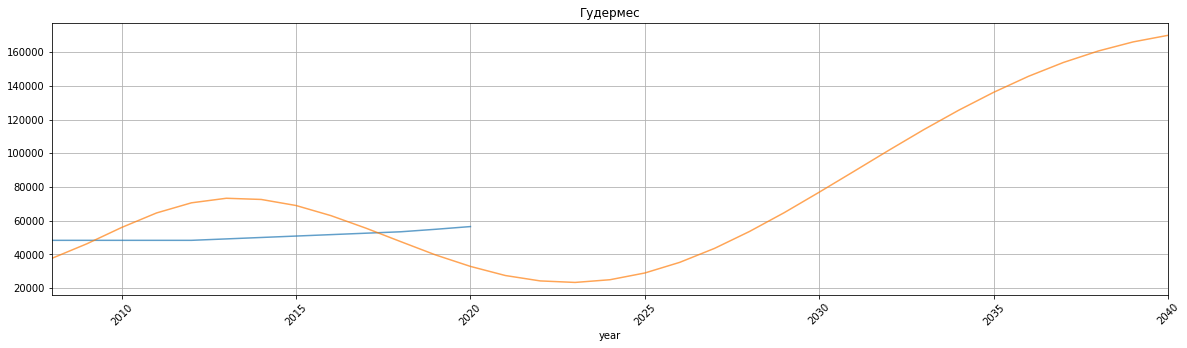

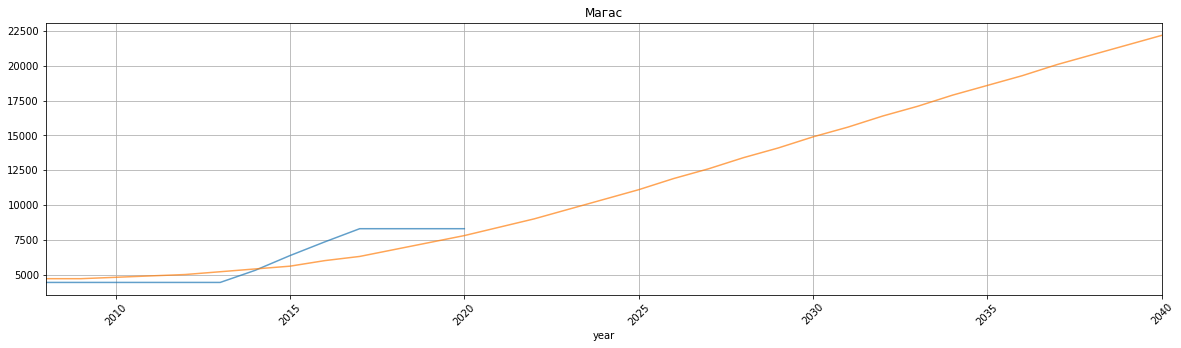

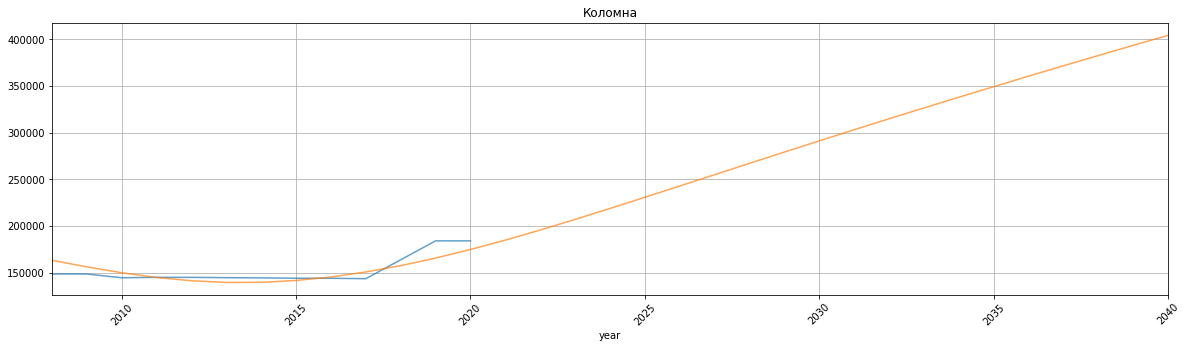

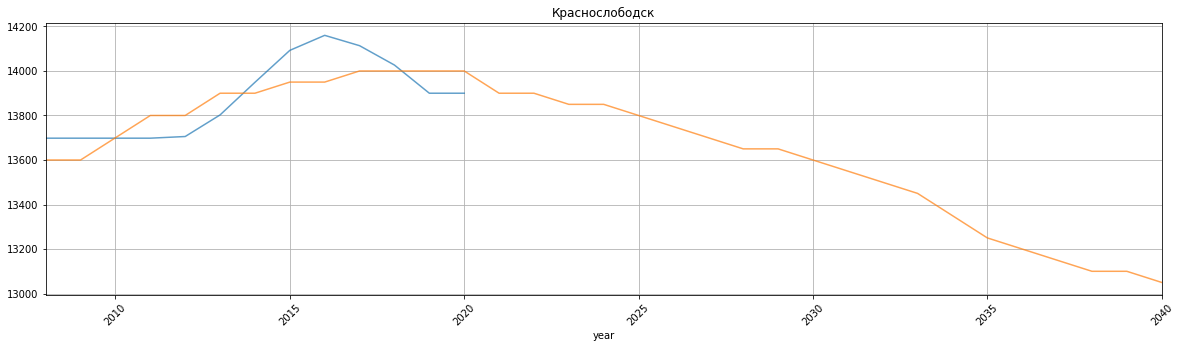

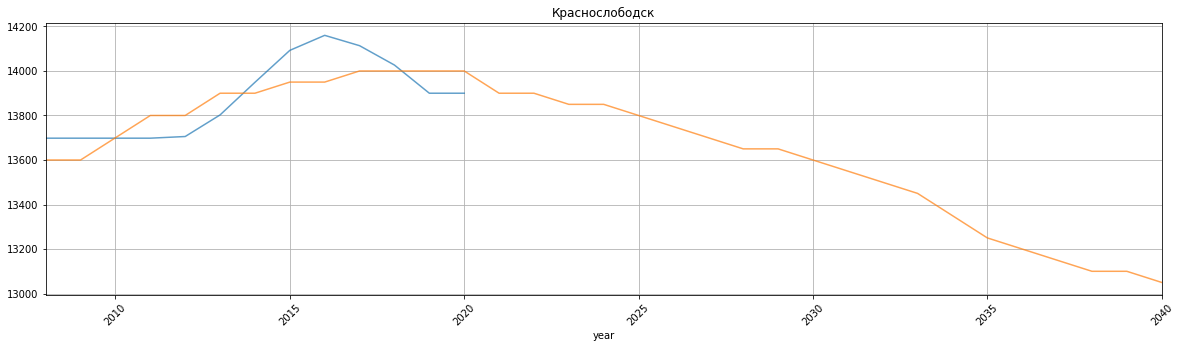

In [10]:
display('Топ 5 городов по прогнозам модели к 2040')
top_10_citys_model = citys_08_20_40.sort_values(by='model_dinamik', ascending=False).head(5)
display(top_10_citys_model[['city','fact_2020','model_2040','model_dinamik']].reset_index(drop=True))
show_graph(citys, top_10_citys_model)

'Топ 5 худьших городов по прогнозам модели к 2040'

,city,fact_2020,model_2040,model_dinamik
0,Гудермес,56521.0,169900.0,3.005962
1,Магас,8295.0,22200.0,2.676311
2,Коломна,183980.0,404400.0,2.198065
3,Краснослободск,9229.0,18900.0,2.047893
4,Краснослободск,9229.0,18900.0,2.047893


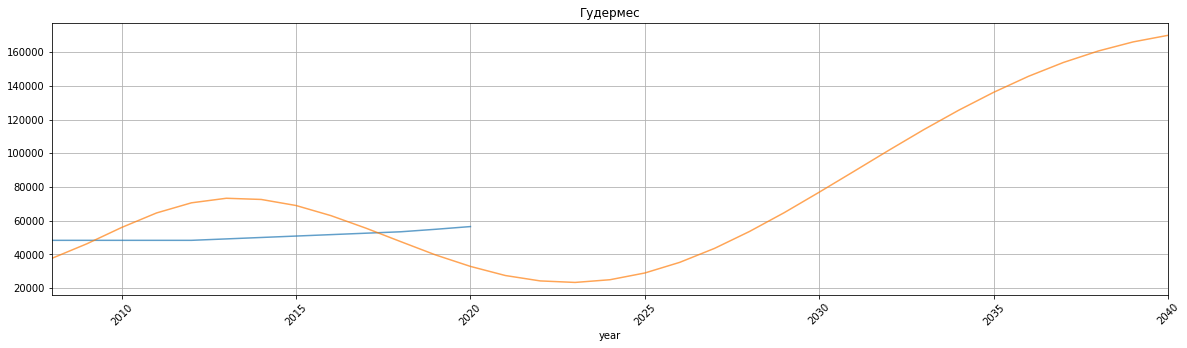

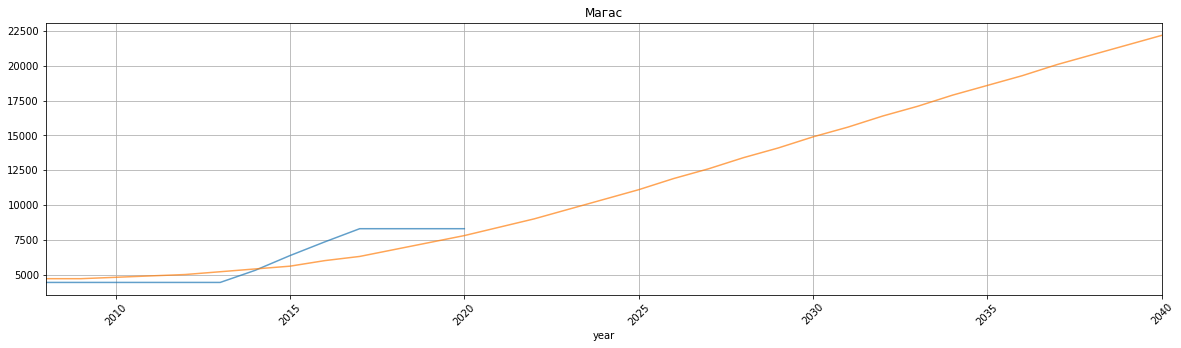

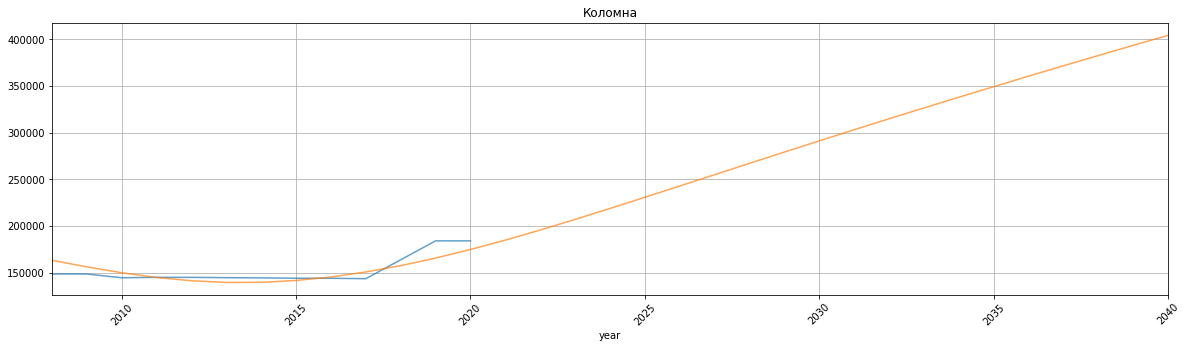

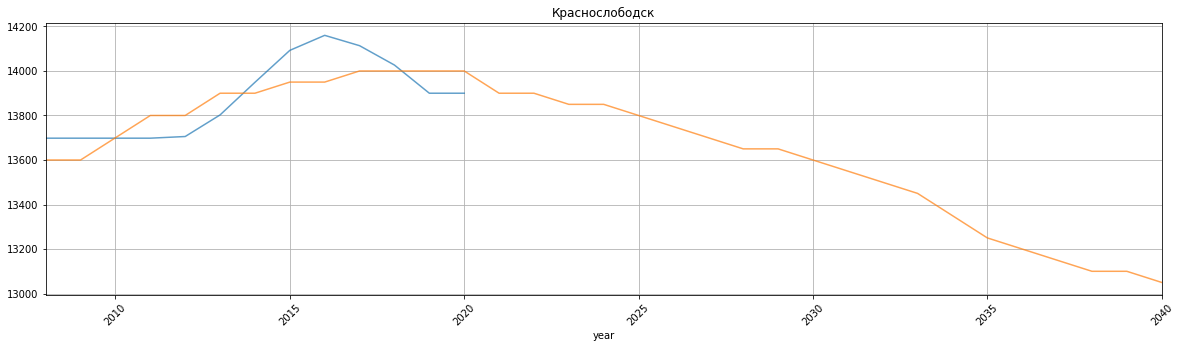

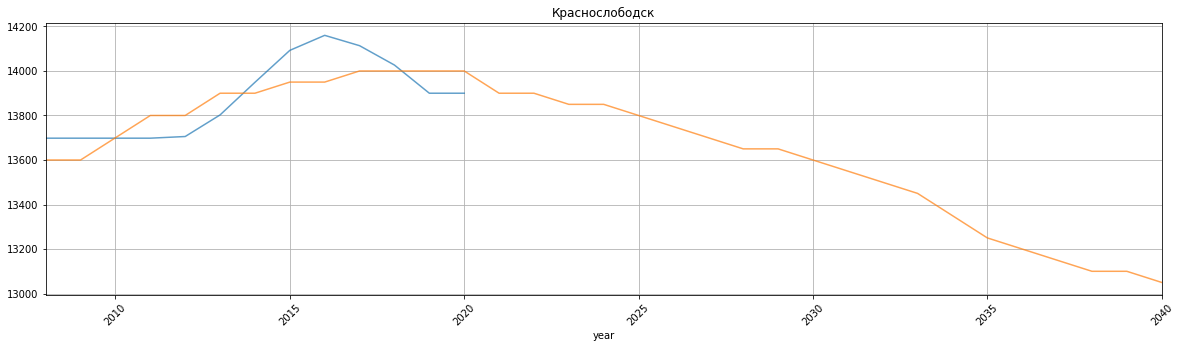

In [11]:
display('Топ 5 худьших городов по прогнозам модели к 2040')
top_10_citys_model = citys_08_20_40.sort_values(by='model_dinamik', ascending=False).head(5)
display(top_10_citys_model[['city','fact_2020','model_2040','model_dinamik']].reset_index(drop=True))
show_graph(citys, top_10_citys_model)

# Выводы:
Не все города, население которых выросло с 2008 по 2020 продолжают расти по численности населения.
Больше половины городов из топа по росту на данный момент имеют отрицательную динамику.

Так же можно сделать другие отчеты по другим временым отрезкам.